# Convolutional Neural Network Example

Build a convolutional neural network with TensorFlow.

This example is using TensorFlow layers API, see 'convolutional_network_raw' example
for a raw TensorFlow implementation with variables.

- Author: Aymeric Damien
- Project: https://github.com/aymericdamien/TensorFlow-Examples/

## CNN Overview

![CNN](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [1]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

/Users/nityamshrestha/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
# Training Parameters
learning_rate = 0.001
num_steps = 2000
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [4]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

In [5]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [6]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/5q/3j2zfpvd0r791sptljlwfsnm0000gn/T/tmp6qoy5f0x', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c21b637f0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [7]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
x={'images': mnist.train.images}, y=mnist.train.labels,
batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/5q/3j2zfpvd0r791sptljlwfsnm0000gn/T/tmp6qoy5f0x/model.ckpt.
INFO:tensorflow:loss = 2.334608, step = 1
INFO:tensorflow:global_step/sec: 7.54852
INFO:tensorflow:loss = 0.06558949, step = 101 (13.248 sec)
INFO:tensorflow:global_step/sec: 7.60356
INFO:tensorflow:loss = 0.061443757, step = 201 (13.152 sec)
INFO:tensorflow:global_step/sec: 7.53898
INFO:tensorflow:loss = 0.10614529, step = 301 (13.265 sec)
INFO:tensorflow:global_step/sec: 7.48185
INFO:tensorflow:loss = 0.025860744, step = 401 (13.365 sec)
INFO:tensorflow:global_step/sec: 7.58951
INFO:tensorflow:loss = 0.027146798, step = 501 (13.176 sec)
INFO:tensorflow:global_step/sec: 7.55315
INFO:tensorflow:loss = 0.010871774, step = 601 (13.239 sec

In [8]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-05-02:08:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/5q/3j2zfpvd0r791sptljlwfsnm0000gn/T/tmp6qoy5f0x/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-05-02:08:59
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.991, global_step = 2000, loss = 0.029767383


{'accuracy': 0.991, 'global_step': 2000, 'loss': 0.029767383}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/5q/3j2zfpvd0r791sptljlwfsnm0000gn/T/tmp6qoy5f0x/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


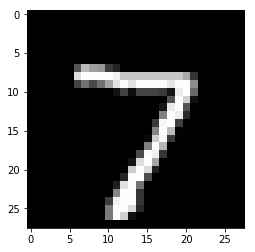

Model prediction: 7


In [9]:
# Predict single images
n_images = 1
# Get images from test set
test_images = mnist.test.images[:n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])

In [ ]:
# Below is the code that converts image into mnist type image

In [13]:
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt

In [14]:
def imageprepare(argv):
    """
    This function returns the pixel values.
    The imput is a png file location.
    """
    im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28, 28), (255))  # creates white canvas of 28x28 pixels

    if width > height:  # check which dimension is bigger
        # Width is bigger. Width becomes 20 pixels.
        nheight = int(round((20.0 / width * height), 0))  # resize height according to ratio width
        if (nheight == 0):  # rare case but minimum is 1 pixel
            nheight = 1
            # resize and sharpen
        img = im.resize((20, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))  # calculate horizontal position
        newImage.paste(img, (4, wtop))  # paste resized image on white canvas
    else:
        # Height is bigger. Heigth becomes 20 pixels.
        nwidth = int(round((20.0 / height * width), 0))  # resize width according to ratio height
        if (nwidth == 0):  # rare case but minimum is 1 pixel
            nwidth = 1
            # resize and sharpen
        img = im.resize((nwidth, 20), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))  # caculate vertical pozition
        newImage.paste(img, (wleft, 4))  # paste resized image on white canvas

    # newImage.save("sample.png

    tv = list(newImage.getdata())  # get pixel values

    # normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    tva = [(255 - x) * 1.0 / 255.0 for x in tv]
#     print(tva)
    return tva


In [15]:
pic = [imageprepare('./pure_image/3.png')]#file path here
pic = np.array(pic)
pic = pic.astype(np.float32)

In [18]:
pic.shape

(1, 784)

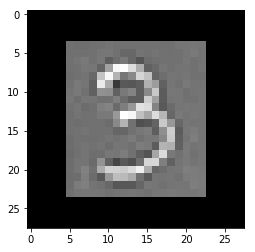

In [19]:
plt.imshow(np.reshape(pic, [28, 28]), cmap='gray')

In [20]:
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': pic}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/5q/3j2zfpvd0r791sptljlwfsnm0000gn/T/tmp6qoy5f0x/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


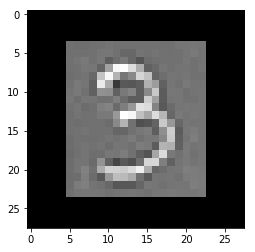

Model prediction: [8]


In [21]:
plt.imshow(np.reshape(pic, [28, 28]), cmap='gray')
plt.show()
print("Model prediction:", preds)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/5q/3j2zfpvd0r791sptljlwfsnm0000gn/T/tmp6qoy5f0x/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


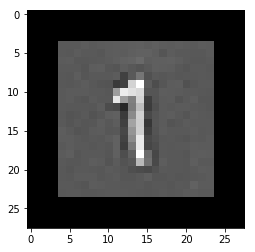

Model prediction: [1]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/5q/3j2zfpvd0r791sptljlwfsnm0000gn/T/tmp6qoy5f0x/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


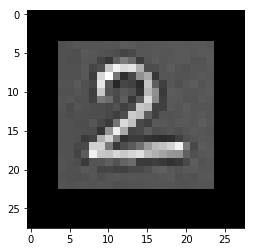

Model prediction: [2]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/5q/3j2zfpvd0r791sptljlwfsnm0000gn/T/tmp6qoy5f0x/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


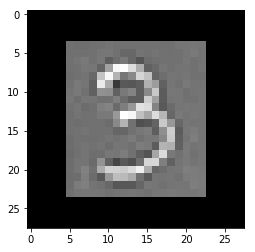

Model prediction: [8]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/5q/3j2zfpvd0r791sptljlwfsnm0000gn/T/tmp6qoy5f0x/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


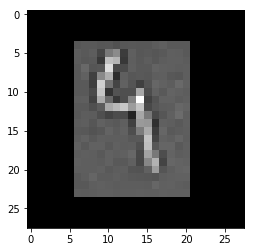

Model prediction: [8]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/5q/3j2zfpvd0r791sptljlwfsnm0000gn/T/tmp6qoy5f0x/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


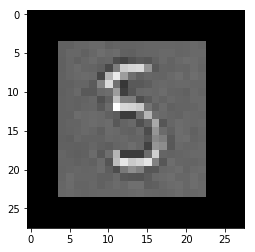

Model prediction: [0]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/5q/3j2zfpvd0r791sptljlwfsnm0000gn/T/tmp6qoy5f0x/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


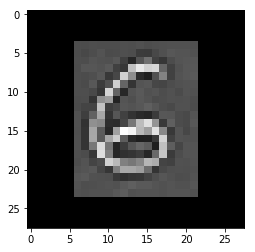

Model prediction: [8]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/5q/3j2zfpvd0r791sptljlwfsnm0000gn/T/tmp6qoy5f0x/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


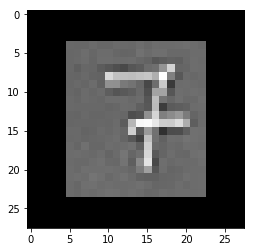

Model prediction: [8]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/5q/3j2zfpvd0r791sptljlwfsnm0000gn/T/tmp6qoy5f0x/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


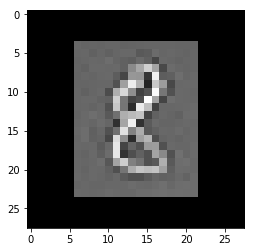

Model prediction: [8]
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/5q/3j2zfpvd0r791sptljlwfsnm0000gn/T/tmp6qoy5f0x/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


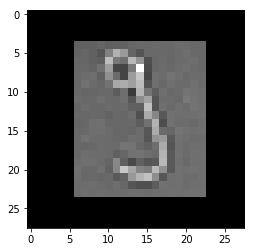

Model prediction: [0]


In [22]:
for x in range(1,10):
    path = './pure_image/'+ str(x) + '.png';
    pic = [imageprepare(path)]#file path here
    pic = np.array(pic)
    pic = pic.astype(np.float32)
    
    input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': pic}, shuffle=False)
# Use the model to predict the images class
    preds = list(model.predict(input_fn))
    plt.imshow(np.reshape(pic, [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds)

In [ ]:
# ----- END HERE------- #
# After this is new algorithm for converting image that didn't work, so don't worry about it rn

In [11]:
def image_maker(path):
    imfile = path;
    im = double(rgb2gray(imread(imfile))); #double and convert to grayscale
    im = imresize(im,[28,28]);  #change to 20 by 20 dimension
    im = im(:); #unroll matrix to vector
    im = im./max(im); 
    return im

SyntaxError: invalid syntax (<ipython-input-11-d29fc7fe1c9a>, line 5)

In [ ]:
pic = image_maker('./pure_image/1.png')

Creating own training set

In [ ]:
my_labels = np.array([1,2,3,4,5,6,7,8,9]);

In [ ]:
ip = [imageprepare('./pure_image/1.png')]

In [ ]:
len(ip)

In [ ]:
type(mnist.train.images[0])

In [ ]:
mnist.train.images[0].shape

In [ ]:
my_pics = np.array([imageprepare('./pure_image/1.png'),imageprepare('./pure_image/2.png'),imageprepare('./pure_image/3.png'), imageprepare('./pure_image/4.png'),imageprepare('./pure_image/5.png'), imageprepare('./pure_image/6.png'),imageprepare('./pure_image/7.png'), imageprepare('./pure_image/8.png'),imageprepare('./pure_image/9.png')])

In [ ]:
my_pics.shape

In [ ]:
my_pics = my_pics.astype(np.float32)

In [ ]:
input_fn = tf.estimator.inputs.numpy_input_fn(
x={'images': my_pics}, y=my_labels,
batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

In [ ]:
pic = [imageprepare('./pure_image/2.png')]#file path here


In [ ]:
### test_images = mnist.test.images[:n_images]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])

In [12]:
import os
from PIL import Image
from array import *
from random import shuffle

# Load from and save to
Names = [['./training-images','train'], ['./test-images','test']]

for name in Names:
	
	data_image = array('B')
	data_label = array('B')

	FileList = []
	for dirname in os.listdir(name[0])[1:]: # [1:] Excludes .DS_Store from Mac OS
		path = os.path.join(name[0],dirname)
		for filename in os.listdir(path):
			if filename.endswith(".png"):
				FileList.append(os.path.join(name[0],dirname,filename))

	shuffle(FileList) # Usefull for further segmenting the validation set

	for filename in FileList:

		label = int(filename.split('/')[2])

		Im = Image.open(filename)

		pixel = Im.load()

		width, height = Im.size

		for x in range(0,width):
			for y in range(0,height):
				data_image.append(pixel[y,x])

		data_label.append(label) # labels start (one unsigned byte each)

	hexval = "{0:#0{1}x}".format(len(FileList),6) # number of files in HEX

	# header for label array

	header = array('B')
	header.extend([0,0,8,1,0,0])
	header.append(int('0x'+hexval[2:][:2],16))
	header.append(int('0x'+hexval[2:][2:],16))
	
	data_label = header + data_label

	# additional header for images array
	
	if max([width,height]) <= 256:
		header.extend([0,0,0,width,0,0,0,height])
	else:
		raise ValueError('Image exceeds maximum size: 256x256 pixels');

	header[3] = 3 # Changing MSB for image data (0x00000803)
	
	data_image = header + data_image

	output_file = open(name[1]+'-images-idx3-ubyte', 'wb')
	data_image.tofile(output_file)
	output_file.close()

	output_file = open(name[1]+'-labels-idx1-ubyte', 'wb')
	data_label.tofile(output_file)
	output_file.close()

# gzip resulting files

for name in Names:
	os.system('gzip '+name[1]+'-images-idx3-ubyte')
	os.system('gzip '+name[1]+'-labels-idx1-ubyte')


FileNotFoundError: [Errno 2] No such file or directory: './training-images'